In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

2024-03-16 22:00:19.995547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 22:00:20.615411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [73]:
VEC_POS = 2
ACTION_CLASSES = 17
HAND = ACTION_CLASSES
DECK = ACTION_CLASSES
STATUS_CLASSES = 9
UNIT_ATTRIBUTES = 3

FF_SIZE = 16

unit_input_size = VEC_POS + UNIT_ATTRIBUTES + HAND + DECK + STATUS_CLASSES


def res_block(size: int, block_input: tf.keras.layers.Layer):
    ff = tf.keras.layers.Dense(size, activation='relu')(block_input)
    bnorm = tf.keras.layers.BatchNormalization()(ff)
    return tf.keras.layers.Add()([block_input, bnorm])


def build_model():
    input_layer = tf.keras.layers.Input(shape=(unit_input_size * 2,), name="input_layer")
    norm_input_layer = tf.keras.layers.Normalization()(input_layer)

    input_player = norm_input_layer[:, :48]
    input_monster = norm_input_layer[:, 48:]

    # RES BLOCK
    unit_encode1 = tf.keras.layers.Dense(FF_SIZE)
    unit_encode2 = tf.keras.layers.BatchNormalization()
    unit_encode3 = tf.keras.layers.ReLU()
    unit_encode4 = tf.keras.layers.Dense(FF_SIZE)
    unit_encode5 = tf.keras.layers.BatchNormalization()
    unit_encode6 = tf.keras.layers.ReLU()
    unit_encode7 = tf.keras.layers.Dense(FF_SIZE)
    unit_encode8 = tf.keras.layers.Add()

    def encode_unit(unit_inputs):
        x = encoded_i = unit_encode1(unit_inputs)
        x = unit_encode2(x)
        x = unit_encode3(x)
        x = unit_encode4(x)
        x = unit_encode5(x)
        x = unit_encode6(x)
        x = unit_encode7(x)
        return unit_encode8([x, encoded_i])

    encode_player = encode_unit(input_player)
    encode_monster = encode_unit(input_monster)

    concat = tf.keras.layers.Concatenate()([encode_player, encode_monster])
    ff3 = tf.keras.layers.Dense(16, activation='relu')(concat)
    dropout = tf.keras.layers.Dropout(0.2)(ff3)
    ff4 = tf.keras.layers.Dense(2)(dropout)
    activation = tf.keras.layers.ReLU(max_value=1.0, name="activation")(ff4)

    output_layer = activation
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 96)]         0           []                               
                                                                                                  
 normalization_18 (Normalizatio  (None, 96)          193         ['input_19[0][0]']               
 n)                                                                                               
                                                                                                  
 tf.__operators__.getitem_36 (S  (None, 48)          0           ['normalization_18[0][0]']       
 licingOpLambda)                                                                                  
                                                                                           

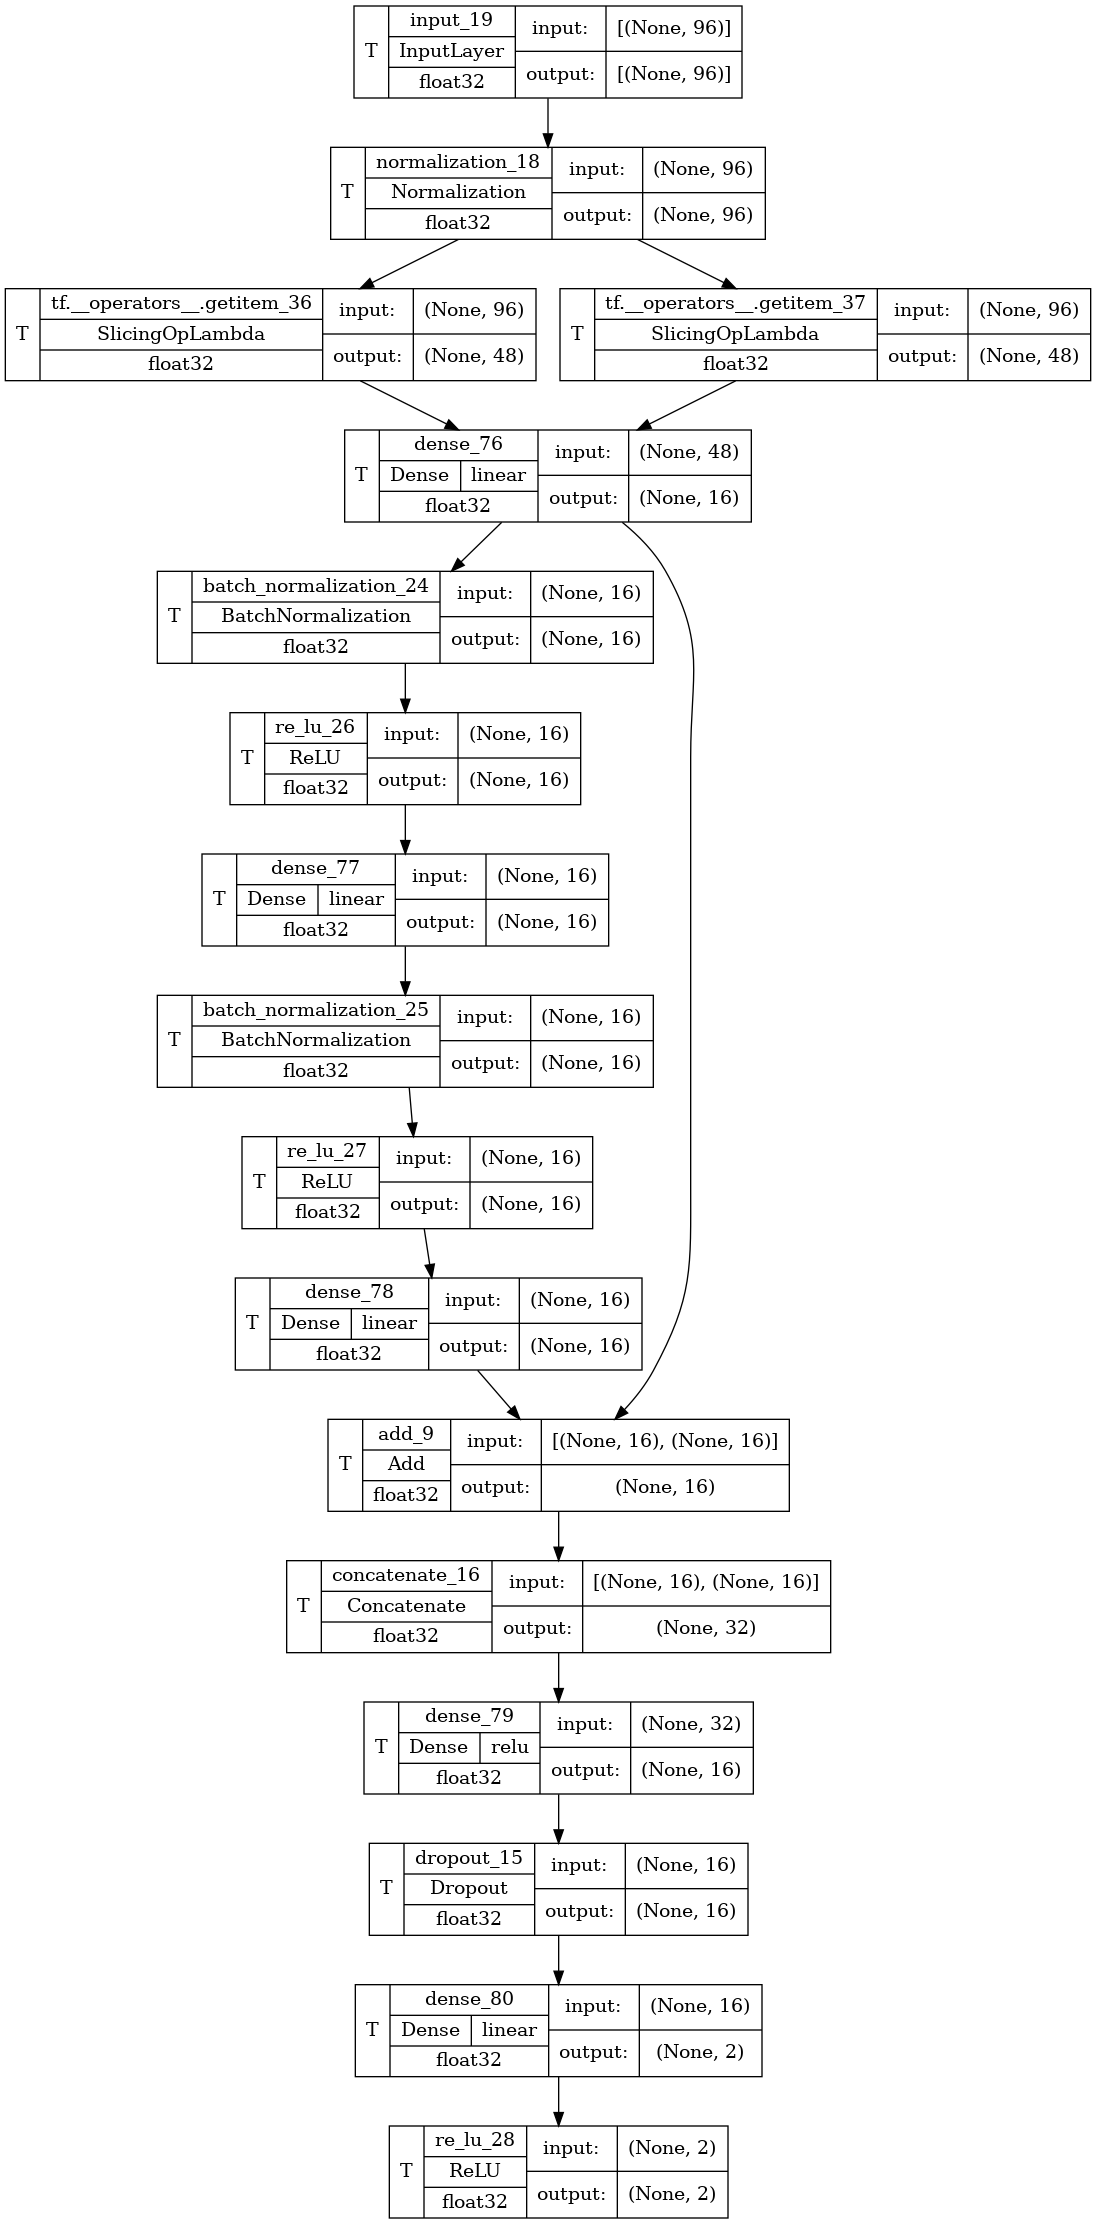

In [74]:
model = build_model()
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [54]:
path = "../gaf6/generated/"
csv_frames = []  # pd.read_csv(path + "data.csv")
with open("../win_predictor_headers.txt") as f:
    headers = list(line.rstrip("\n") for line in f)

for file in os.listdir(path):
    if not file.endswith(".csv"):
        continue

    filepath = path + file
    cdf = pd.read_csv(filepath, names=headers)
    csv_frames.append(cdf)

df = pd.concat(csv_frames, axis=0, ignore_index=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114873 entries, 0 to 114872
Data columns (total 98 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PLAYER_x                        114873 non-null  int64  
 1   PLAYER_y                        114873 non-null  int64  
 2   PLAYER_hp                       114873 non-null  int64  
 3   PLAYER_mhp                      114873 non-null  int64  
 4   PLAYER_spd                      114873 non-null  int64  
 5   PLAYER_DECK_COMBINE_ACTIONS     114873 non-null  int64  
 6   PLAYER_DECK_WRATHSPARK          114873 non-null  int64  
 7   PLAYER_DECK_GROUNDRAISE         114873 non-null  int64  
 8   PLAYER_DECK_TREAD               114873 non-null  int64  
 9   PLAYER_DECK_COILBLADE           114873 non-null  int64  
 10  PLAYER_DECK_ETERNALSHACLES      114873 non-null  int64  
 11  PLAYER_DECK_NETHERSWAP          114873 non-null  int64  
 12  PLAYER_DECK_WISP

,PLAYER_x,PLAYER_y,PLAYER_hp,PLAYER_mhp,PLAYER_spd,PLAYER_DECK_COMBINE_ACTIONS,PLAYER_DECK_WRATHSPARK,PLAYER_DECK_GROUNDRAISE,PLAYER_DECK_TREAD,PLAYER_DECK_COILBLADE,...,MONSTER_STATUS_SLOW,MONSTER_STATUS_COUNTDOWN,MONSTER_STATUS_SHACLES,MONSTER_STATUS_DUSTED,MONSTER_STATUS_SPIRITING,MONSTER_STATUS_IMMOLATION,MONSTER_STATUS_CORE_ARMOR,MONSTER_STATUS_HOARFROST_ARMOR,WINNER_P,WINNER_M
0,5,5,1,14,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0.0,1.0
1,8,5,11,12,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.0,0.0
2,0,6,11,12,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.0,0.0
3,0,6,11,12,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.0,0.0
4,0,6,11,12,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1.0,0.0


In [55]:
# data augmentation
column_names = list(df.columns)
desired_order = column_names[48:-2] + column_names[:48] + [column_names[-1], column_names[-2]]

inverted_df = df[desired_order].rename(columns=dict(zip(desired_order, column_names)))
df = pd.concat([df, inverted_df], axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229746 entries, 0 to 229745
Data columns (total 98 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PLAYER_x                        229746 non-null  int64  
 1   PLAYER_y                        229746 non-null  int64  
 2   PLAYER_hp                       229746 non-null  int64  
 3   PLAYER_mhp                      229746 non-null  int64  
 4   PLAYER_spd                      229746 non-null  int64  
 5   PLAYER_DECK_COMBINE_ACTIONS     229746 non-null  int64  
 6   PLAYER_DECK_WRATHSPARK          229746 non-null  int64  
 7   PLAYER_DECK_GROUNDRAISE         229746 non-null  int64  
 8   PLAYER_DECK_TREAD               229746 non-null  int64  
 9   PLAYER_DECK_COILBLADE           229746 non-null  int64  
 10  PLAYER_DECK_ETERNALSHACLES      229746 non-null  int64  
 11  PLAYER_DECK_NETHERSWAP          229746 non-null  int64  
 12  PLAYER_DECK_WISP

In [56]:
predict = ["WINNER_P", "WINNER_M"]

df.dropna(inplace=True)
X = np.array(df.drop(predict, axis=1))  # Features
y = np.array(df[predict])  # Labels

In [75]:
model.layers[1].adapt(X)

In [58]:
d = {}
dupes = 0
total_rows = 0

action_count = 18
baseline = [0] * action_count
culprit = [0] * action_count

for row in df.iterrows():
    total_rows += 1
    index, *row_data = row
    *key, value1, value2 = row_data[0]
    value = (value1, value2)
    tkey = tuple(key)

    for i in range(18):
        baseline[i] += tkey[i]

    if tkey in d:
        dupes += 1
        same = (d[tkey] == value)

        if same:
            continue

        print("!!! High Difference duplicate !!!")
        print(f"existing: {d[tkey]} \tnew: {value}")
        print(f"key: {tkey}")


    else:
        d[tkey] = value
    # break
print(f"total dupes {dupes} ({round(dupes / total_rows * 100)}%)")

KeyboardInterrupt: 

In [76]:
model.fit(X, y, validation_split=0.1, epochs=25, batch_size=256, shuffle=True)

Epoch 1/25
802/802 [==============================] - 9s 9ms/step - loss: 0.2260 - accuracy: 0.6586 - val_loss: 0.1667 - val_accuracy: 0.6662
Epoch 2/25
802/802 [==============================] - 7s 9ms/step - loss: 0.1497 - accuracy: 0.7183 - val_loss: 0.1515 - val_accuracy: 0.7106
Epoch 3/25
802/802 [==============================] - 8s 10ms/step - loss: 0.1400 - accuracy: 0.7476 - val_loss: 0.1490 - val_accuracy: 0.7271
Epoch 4/25
802/802 [==============================] - 8s 10ms/step - loss: 0.1346 - accuracy: 0.7607 - val_loss: 0.1449 - val_accuracy: 0.7401
Epoch 5/25
802/802 [==============================] - 8s 10ms/step - loss: 0.1308 - accuracy: 0.7717 - val_loss: 0.1418 - val_accuracy: 0.7463
Epoch 6/25
802/802 [==============================] - 8s 10ms/step - loss: 0.1276 - accuracy: 0.7777 - val_loss: 0.1401 - val_accuracy: 0.7488
Epoch 7/25
802/802 [==============================] - 8s 11ms/step - loss: 0.1249 - accuracy: 0.7856 - val_loss: 0.1384 - val_accuracy: 0.7609
E

In [77]:
loss, accuracy = model.evaluate(X, y)

def sigmoid(logits):
    # converts from -inf, inf to 0-1 range
    return 1 / (1 + np.exp(-logits))


def rounded(data):
    return round(data[0], 2), round(data[1], 2)


for i in range(20):
    random_index = random.randint(0, len(df - 1) // 2)
    data = df.loc[random_index]
    ground_truth = data[-2], data[-1]
    log_prediction = model.predict(np.expand_dims(data[:-2], axis=0), )[0]
    # prediction = sigmoid(log_prediction)
    prediction = log_prediction
    print(
        f"Data({random_index})\tTruth:{ground_truth}\tPred:{rounded(prediction)}\t(log: {rounded(prediction)})")

1/1 [==============================] - 0s 79ms/step
Data(101195)	Truth:(0.0, 0.0)	Pred:(0.0, 0.0)	(log: (0.0, 0.0))
1/1 [==============================] - 0s 12ms/step
Data(110795)	Truth:(1.0, 0.0)	Pred:(1.0, 0.0)	(log: (1.0, 0.0))
1/1 [==============================] - 0s 12ms/step
Data(85576)	Truth:(0.0, 1.0)	Pred:(0.04, 0.88)	(log: (0.04, 0.88))
1/1 [==============================] - 0s 14ms/step
Data(54469)	Truth:(0.0, 1.0)	Pred:(0.0, 1.0)	(log: (0.0, 1.0))
1/1 [==============================] - 0s 12ms/step
Data(80765)	Truth:(0.0, 1.0)	Pred:(0.0, 1.0)	(log: (0.0, 1.0))
1/1 [==============================] - 0s 14ms/step
Data(735)	Truth:(1.0, 0.0)	Pred:(0.26, 0.62)	(log: (0.26, 0.62))
1/1 [==============================] - 0s 14ms/step
Data(105565)	Truth:(0.0, 0.0)	Pred:(0.0, 0.0)	(log: (0.0, 0.0))
1/1 [==============================] - 0s 17ms/step
Data(18262)	Truth:(0.0, 1.0)	Pred:(0.14, 0.75)	(log: (0.14, 0.75))
1/1 [==============================] - 0s 13ms/step
Data(81259)	Tru

In [78]:
model_save_path = "./winner_predictor_model/"
!mkdir winner_predictor_model

if not os.path.isdir(model_save_path):
    os.mkdir(model_save_path)

tf.saved_model.save(model, model_save_path)


/bin/bash: /home/matpac/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


2024-03-16 22:58:38.215418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]
2024-03-16 22:58:38.585914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,16]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./winner_predictor_model/assets
